# Spectral Analysis on Geophysical Data

On the previous notebook we saw the easiest case of spectral analysis (distinct frequencies). Here we will push further the complexity by analysis real wave data. This analysis rely on wave elevation recorded by a buoy of the Costal Data Information Program (CDIP, same dataset used in the [previous notebook](./wave_by_wave_analysis.ipynb)). I made the choice to focus on data collected by the buoy offshore the San Francisco Bay, however, the present notebook can be applied to all the buoys of the program.

Practically speaking, in this Notebook we perform:

 - Download one-dimensional wave data
   
 - Apply window over the signal to remove the spectral leakage

   
 - Perform the Fourier Analysis

   
 - Compute the Power Spectral Density of the signal

   
 - Correct the windowing process, cc Parseval's theorem

   
 - Interpret the wave spectrum


 - Compute the uncertainty of the spectrum

In [99]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.stats.distributions import chi2


### Functions for the Spectral Analysis

In [83]:
def create_UTC_axis(ds_xyz, arrayIndex):

    """
    Purpose: Create the time axis associated to the motion along x, y, and z dimension
    ----------
    inputs:
    --------
    ds_xyz: the xarray dataset that contain the motions
    arrayIndex: The array of second
    output:
    --------
    time_array: datetime64 object in s. 
    """
    
    arrayIndex = xr.DataArray(arrayIndex, attrs={'units': 'nb_of_obs'}).astype('timedelta64[s]')

    
    sample_rate_sec = xr.DataArray(ds_xyz.xyzSampleRate.values, attrs={'units': 's'}).astype('timedelta64[s]')
    filter_delay_sec = xr.DataArray(ds_xyz.xyzFilterDelay.values, attrs={'units': 's'}).astype('timedelta64[s]')
    time_axis = xr.DataArray(arrayIndex/sample_rate_sec, attrs={'units': 's'}).astype('timedelta64[s]')

    time_array = ds_xyz.xyzStartTime.values + time_axis - filter_delay_sec
    return time_array

def wave_frequency_spectrum(elevation, Fs = 1.2):
    """
    Purpose: Perform the frequency spectrum of the elevation signal
    ----------
    inputs:
    --------
    elevation: the motion along z (elevation induced by waves)
    Fs: The sampling frequency
    
    output:
    --------
     freq: the frequency axis
     spec_corr: the wave frequency spectrum. _corr stand for correction of the windowing
    """
    
    nfft = len(elevation)  # The number of point for the spectral analysis
    
    Nf = int(nfft/2 + 1)  # The number of frequencies
    # Nf = 200
    df = Fs/nfft  # The spectral resolution
    freq = np.linspace(df, df*(Nf-1), (Nf-1))  # Define the frequency axis

    #########
    # --- The heart of the spectral analysis
    #########
    
    hanningt = 0.5 * (1-np.cos(2*np.pi*np.linspace(0, nfft-1, nfft)/(nfft-1)))  # Hanning window
    wc2t = 1/np.mean(hanningt**2)  # Correction factor
    Zw = (elevation-np.mean(elevation)) * hanningt  # Apply the window to avoid spectral leakage (put to 0 the extrema) + detrend
    Zf = np.fft.fft(Zw, nfft, axis = 0)/nfft  # Apply the Fourier Transform
    spec = abs(Zf)**2 / df  # Compute the power spectral density
    spec_folded = 2 * spec[1:Nf]

    hs_spec = 4 * np.sqrt(np.sum(spec_folded)*df)
    #print(f'The significant wave height associated to the spectrum is {hs_spec} m')
    #print('\n')
    #print(f'The significant wave height associated to the elevation is {4 * np.sqrt(elevation.var())} m')

    spec_corr =  spec_folded * wc2t  # Correct the spectrum
    hs_spec_corr = 4 * np.sqrt(np.sum(spec_corr)*df)
    #print(f'The significant wave height associated to the spectrum is {hs_spec_corr} m')

    return freq, spec_corr


def wave_frequency_spectrum_overlap(elevation, overlap, nfft,  Fs = 1.2):

    """
    Purpose: Perform the frequency spectrum of the elevation signal with the signal cut in segments with overlap
    ----------
    inputs:
    --------
    elevation: the motion along z (elevation induced by waves)
    overlap: the overlap between segments in %
    nfft: tthe number of point per segments
    Fs: The sampling frequency
    
    output:
    --------
     freq: the frequency axis
     spec_corr_mean: the mean wave frequency spectrum. _corr stand for correction of the windowing
    """  
    Nf = int(nfft/2 + 1) # The number of frequencies
    NS1 = len(elevation)//nfft # The number point per segment
    ov = overlap/100 # percentage of overlap between segments
    NS = NS1 * (1 + 2*ov) - 2 * ov # number of point per segment
    
    Eh = np.ones((int(NS), 1)) # Initialize array of NS pts
    hanningt = 0.5 * (1-np.cos(2*np.pi*np.linspace(0, nfft-1, nfft)/(nfft-1))) # Hanning window

    H = hanningt * Eh # 1d window
    elevmat = np.zeros((nfft, int(NS))) # initialize matrix of length of spectrum times n_seg
    vec_i = np.arange(0, NS, 1)
    print(f'We chunk the signal into {int(NS)} windows')

    df = Fs/nfft # frequency resolution
    # freq = np.linspace(df, df*(Nf-1), (Nf - 1)) # frequency axis

    for iw in range(len(vec_i)): # fill matrix of sub sample
        nstart = np.floor((iw-1+1)*(1 - ov) * nfft)
        nend = nstart + nfft
        elevmat[:, iw] = elevation[int(nstart):int(nend)]

    Nf2 = len(elevmat[:, -1])//2 # I take the last window, but any one work
    freq = np.linspace(df, df*(Nf2-1), (Nf2)) # frequency axis

    elevmat2 = elevmat.T
    
    wc2t = 1/np.mean(hanningt**2) # correction factor
    Zw = (elevmat2-np.mean(elevmat2)) * hanningt # Windowed signals + remove trend

    Zf = np.fft.fft(Zw, nfft, axis = 1)/nfft # Fourier transform of the windowed signals

    spec = abs(Zf)**2  / (df) # Power spectral density of the spectra
    spec_folded = 2 * spec[:, 0:np.size(spec, axis = 1)//2] # Fold the spectrum
    spec_corr = spec_folded * wc2t # correct the spectrum because of window
    spec_corr_mean = np.mean(spec_corr, axis = 0).T # mean spectrum

    return freq, spec_corr_mean


def confident_interval_spec_95(Ef, n_spec):
    """ The 95% confident interval of the spectrum
    input: 
    Ef: The Power Spectral Density (PSD)
    n_spec: Number of spectra used for the mean PSD
    
    outputs:
    Ef_low: The low PSD
    Ef_up: The up PSD
    """
    low_bound=0.025
    up_bound=0.975
    Ef_low=chi2.ppf(low_bound, df=2*n_spec)*Ef/(2*n_spec)
    Ef_up=chi2.ppf(up_bound, df=2*n_spec)*Ef/(2*n_spec)
    
    return Ef_low,Ef_up

### Load data

In [84]:
file_url_data = './data/motion_wave_data_cdip.nc'
file_url_param = './data/spectral_wave_data_cdip.nc'

ds_buoy = xr.open_dataset(file_url_data)
ds_operationel = xr.open_dataset(file_url_param)

n_data = 3000

arrayIndex = np.linspace(0, n_data, n_data) # an array of ~ 30 min
time_UTC = create_UTC_axis(ds_buoy, arrayIndex)
elevation =  ds_buoy.xyzZDisplacement[:len(arrayIndex)] # work on a 30 min window

In [87]:
ds_operation_sel = ds_operationel.sel(waveTime = slice(time_UTC[0], time_UTC[-1])) # Select a record length of n_data obs.

In [100]:
ds_operation_sel

<xarray.Dataset> Size: 334kB
Dimensions:                     (sourceCount: 1951, waveTime: 2,
                                 metaBoundsCount: 2, waveFrequency: 64,
                                 sstTime: 1950, gpsTime: 1950, dwrTime: 1950)
Coordinates:
  * waveTime                    (waveTime) datetime64[ns] 16B 2025-09-06T22:0...
  * waveFrequency               (waveFrequency) float32 256B 0.025 0.03 ... 0.58
  * sstTime                     (sstTime) datetime64[ns] 16kB 2025-09-06T22:2...
  * gpsTime                     (gpsTime) datetime64[ns] 16kB 2025-09-06T22:2...
  * dwrTime                     (dwrTime) datetime64[ns] 16kB 2025-09-06T22:0...
    metaDeployLatitude          float32 4B ...
    metaDeployLongitude         float32 4B ...
Dimensions without coordinates: sourceCount, metaBoundsCount
Data variables: (12/51)
    sourceFilename              (sourceCount) object 16kB b'is70420_202509062...
    waveTimeBounds              (waveTime, metaBoundsCount) datetime64[ns] 32B ...
    waveFlagPrimary             (waveTime) float32 8B 1.0 1.0
    waveFlagSecondary           (waveTime) float32 8B 0.0 0.0
    waveHs                      (waveTime) float32 8B 1.11 1.07
    waveTp                      (waveTime) float32 8B 13.33 15.38
    ...                          ...
    metaStationName             |S28 28B b'POINT REYES, CA BUOY - 029p1'
    metaPlatform                |S1 1B ...
    metaInstrumentation         |S1 1B ...
    metaWaterDepth              float32 4B ...
    metaDeclination             float32 4B ...
    metaGridMapping             |S1 1B ...
Attributes: (12/66)
    naming_authority:                edu.ucsd.cdip
    keywords_vocabulary:             Global Change Master Directory (GCMD) Ea...
    date_created:                    2025-10-17T16:30:22Z
    date_issued:                     2025-10-17T16:30:22Z
    date_modified:                   2025-10-17T16:30:22Z
    creator_name:                    Coastal Data Information Program, SIO/UCSD
    ...                              ...
    time_coverage_resolution:        PT30M
    source:                          insitu observations
    instrument:                      metaInstrumentation
    platform:                        wave_buoy
    platform_vocabulary:             http://mmisw.org/ont/ioos/platform
    platform_name:                   POINT REYES, CA BUOY - 029p1

In [90]:
mean_spec_operational = ds_operation_sel.waveEnergyDensity.mean(dim = 'waveTime') # get the mean reference spectrum

In [91]:
fmax = ds_operationel.waveFrequency.max().values # get the highest frequency in the reference Dataset
fs = 2*fmax # the sampling frequency is twice the highest frequency resolved in the reference dataset (Nyquist)

### The wave elevation signal. The signal we are processing.

Text(0, 0.5, 'Wave Amplitude [m]')

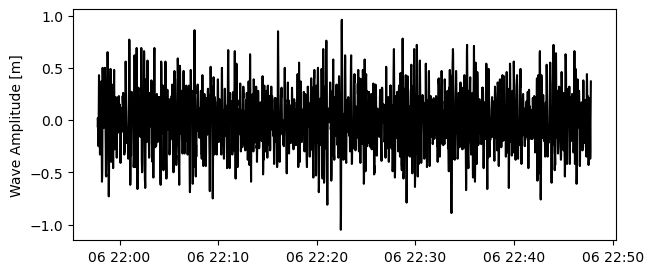

In [92]:
fig, ax = plt.subplots(figsize = (7, 3))
ax.plot(time_UTC, elevation, color = 'k')
ax.set_ylabel('Wave Amplitude [m]')

### 

In [93]:
freq_raw, spec_raw = wave_frequency_spectrum(elevation.values, ds_buoy.xyzSampleRate.values) # The raw spectral analysis
freq_smooth, spec_corr_mean = wave_frequency_spectrum_overlap(elevation.values, 50, 150,  Fs = ds_buoy.xyzSampleRate.values) # The Welch Method

We chunk the signal into 39 windows


This method of chunk the total signal into sub-signal is called the Welch's method. Don't forget to window all the chunks to avoid spectral leakage.

### Plots the Spectra

Text(0.5, 1.0, '')

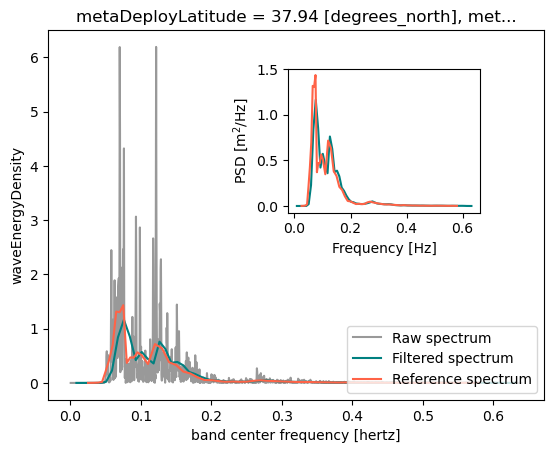

In [102]:
fig, ax = plt.subplots()
ax_inset = fig.add_axes([.5, .5, .3, .3])
ax.plot(freq_raw, spec_raw, color = 'k', alpha = .4, label = 'Raw spectrum')

ax.plot(freq_smooth, spec_corr_mean, color = 'teal', label = 'Filtered spectrum')
mean_spec_operational.plot(ax = ax, color = 'tomato', label = 'Reference spectrum')
ax.legend(loc = 4)
ax_inset.plot(freq_smooth, spec_corr_mean, color = 'teal')
mean_spec_operational.plot(ax = ax_inset, color = 'tomato')
ax_inset.set_xlabel('Frequency [Hz]')
ax_inset.set_ylabel('PSD [m$^2$/Hz]')
ax_inset.set_title('')

### Wave characteristics: let's spot the dominant wave frequencies (periods) and the significant wave height

In [97]:
peaks_spectrum = find_peaks(spec_corr_mean, height = .5)[0] # here, the present height threshold is only applicable for this record 

df = np.gradient(freq_smooth)

hs_raw = 4*np.sqrt(np.nanvar(elevation))
hs_spec = 4*np.sqrt(np.nansum(spec_corr_mean*df))
hs_ope = ds_operation_sel.waveHs.mean(dim = 'waveTime').values

print(f'There are {len(peaks_spectrum)} peaks in the spectrum centered at {freq_smooth[peaks_spectrum]} Hz which are associated with {1/freq_smooth[peaks_spectrum]} sec period')
print('\n')
print(f'The significant wave heigth from the raw elevation signal is {hs_raw} m and {hs_spec} m from the spectrum. The reference dataset yields {hs_ope} m')

There are 3 peaks in the spectrum centered at [0.07587748 0.10113154 0.12638558] Hz which are associated with [13.179141  9.888112  7.912295] sec period


The significant wave heigth from the raw elevation signal is 1.0830532312393188 m and 1.0741991975847065 m from the spectrum. The reference dataset yields 1.090000033378601 m


### Results
We are able to reproduce the spectrum provided by CDIP quite well with our analysis. However, a noticeable shift exists between the blue and red spectra. This can be explained by differences in the frequency axis — which can be verified by interpolating our axis onto theirs — and by the fact that we did not use the exact same input signal. It is also possible that our signal is slightly shifted in time.

We identify N peaks in the spectrum, centered around (see above) Hz. These peaks correspond to distinct wave systems. The lowest-frequency peak represents the swell, which is generated remotely and is independent of local wind conditions. The higher-frequency peaks likely correspond either to another distant swell or to a locally generated wind sea. Wind-sea waves are shorter, wind-dependent waves that result in a choppier sea surface. One can note that we have characterized the wave field using only Nf spectral values (length[PSD(f)]), while the original time series contained about 3000 data points. In the present context—where our goal is to derive key parameters such as the dominant wave periods and the significant wave height ($H_s$)—saving the full wave spectrum is not necessary. Only a few values are sufficient (four in our case, corresponding to three dominant periods and one $H_s$). Representing the wave field through spectra is therefore far more efficient than storing the raw elevation data.

Here we are in deep water regime, so one can wonder how long those waves are. Knowing the wavelength we can actually double-check if we are in a deep water regime.

### Uncertainties

As with any mean of random variables (in this case, spectra), the resulting mean spectrum is associated with an uncertainty. More precisely, the mean corresponds to the average of a variance. According to Cochran’s theorem, the sample variance follows a $\chi^{2}$ distribution with N degrees of freedom. Based on Gaussian statistics, the upper and lower 95% confidence bounds for the spectral density, $\mathrm{PSD}(f)$, are determined from the corresponding quantiles of the $\chi^{2}$ distribution. The uncertainty decreases as the number of degrees of freedom increases. Here, the number of degrees of freedom is equal to twice the number of independent segments (or windows) averaged to compute the mean spectrum.

Text(0.5, 1.0, 'The mean spectrum`s errorbar')

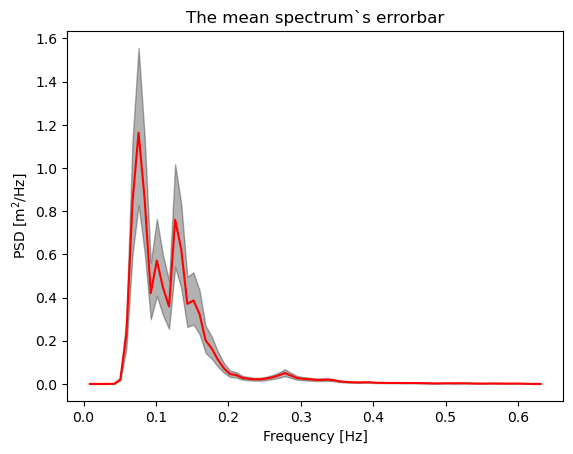

In [98]:
PSD1, PSD2  = confident_interval_spec_95(spec_corr_mean, 39)

fig, ax = plt.subplots()
ax.fill_between(freq_smooth, PSD1, PSD2, alpha = .3, color = 'k')
ax.plot(freq_smooth, spec_corr_mean, color = 'r')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [m$^{2}$/Hz]')
ax.set_title('The mean spectrum`s errorbar')